In [1]:
import os
import re
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from num2words import num2words
import spacy
from deep_translator import GoogleTranslator
from underthesea import text_normalize, classify, sentiment
from wordcloud import WordCloud
import emoji


# Read file
mergecomment = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), "data", "merged", "mergedcomment_20240402_1111.csv"))

In [2]:
# list columns
mergecomment.columns

Index(['link_item', 'data_product_id_list', 'data_product_id', 'name_comment',
       'content_comment', 'product_variant', 'datetime_comment', 'rating'],
      dtype='object')

In [3]:
# Choose the 'content_comment' column
mergecomment = mergecomment[['data_product_id', 'content_comment']]

In [4]:
# 1. Convert to lower case
mergecomment["lower_comment"] = mergecomment["content_comment"].str.lower()
mergecomment.head(10)

,data_product_id,content_comment,lower_comment
0,65994,"Giao lâu, chất lượng + đóng gói oke","giao lâu, chất lượng + đóng gói oke"
1,65994,"thích em này thật sự, mùi thơm thảo mộc, lành ...","thích em này thật sự, mùi thơm thảo mộc, lành ..."
2,65994,Toner này gần như ko mùi Dạng sệt thoa lên da ...,toner này gần như ko mùi dạng sệt thoa lên da ...
3,65994,"Vô thưởng vô phạt, dễ chịu, không mùi Thiết kế...","vô thưởng vô phạt, dễ chịu, không mùi thiết kế..."
4,65994,giao hàng nhanh với cả xài rất tốt í,giao hàng nhanh với cả xài rất tốt í
5,65994,Rất hài lòng,rất hài lòng
6,65994,"toner dưỡng ẩm tốt, mùi thơm dễ chịu","toner dưỡng ẩm tốt, mùi thơm dễ chịu"
7,65994,Sp tốt. Đóng gói cẩn thận. giao hàng trễ,sp tốt. đóng gói cẩn thận. giao hàng trễ
8,65994,"Thực sự là mình ko thích loại này lắm, da mình...","thực sự là mình ko thích loại này lắm, da mình..."
9,65994,da dầu như mình xài êm.thành phần dịu nhẹ,da dầu như mình xài êm.thành phần dịu nhẹ


In [5]:
# 2. Decode abbreviations

# Read file abbreviations
abbs_df = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), "data", "abbreviations.csv"))

# Create a dictionary to map abbreviations to meanings
abbreviation_dict = dict(zip(abbs_df['abbreviation'], abbs_df['meaning']))

# Function to decode abbs
def decode_abbreviations(text, abbreviation_dict):
    # Search for abbreviations in the text and replace them 
    # with their corresponding meanings from the dictionary
    for abbreviation, meaning in abbreviation_dict.items():
        text = re.sub(r'\b' + re.escape(abbreviation) + r'\b', meaning, text)
    return text

# Apply the decode_abbreviations function to the 'content_comment' column
mergecomment["decoded_comment"] = mergecomment["lower_comment"].apply(lambda x: decode_abbreviations(x, abbreviation_dict))


In [6]:
# 3. Translate to English
# Function to translate a batch of sentences from Vietnamese to English
def translate_batch_vietnamese_to_english(texts):
    translated_texts = GoogleTranslator(source='vi', target='en').translate_batch(texts)
    return translated_texts

# Specify the range of rows you want to translate
# 0-500
# 500-1000
# 1000-1500
# 1500-2000
# 2000-2500
# 2500-3000
# 3000-3500
# 3500-4000
# 4000-4500
# 4500-5000
# 5000-end
# start_index = 5000
# end_index = len(mergecomment)

# # Assign the translated comments to the DataFrame directly
# mergecomment.loc[start_index:end_index-1, 'translated_comment'] = translate_batch_vietnamese_to_english(mergecomment['decoded_comment'][start_index:end_index].tolist())

# # Save into csv
# current_datetime = datetime.now().strftime("%Y%m%d_%H%M")
# preprocessed_comment_filename = f"preprocessed_comment_{current_datetime}.csv"

# mergecomment.to_csv(os.path.join(os.path.dirname(os.getcwd()), "data", "preprocessed", "preprocessed_comment", preprocessed_comment_filename), encoding= "utf-8-sig")

In [7]:
# 4. Convert emoji to text
translated_comment = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), "data", "preprocessed", "preprocessed_comment", "preprocessed_comment_20240403_1507.csv"))

# Function converting emoji to text
def demojize_if_str(text):
    if isinstance(text, str): 
        return emoji.demojize(text)
    else:
        return text

# Remove rows with NaN values in the "translated_comment" column
translated_comment.dropna(subset=["translated_comment"], inplace=True)

# Apply the demojize function to the "translated_comment" column
translated_comment["demojized_comment"] = translated_comment["translated_comment"].str.lower().apply(demojize_if_str)

In [8]:
# 5. Remove special characters
translated_comment['standardlized_comment'] = translated_comment['demojized_comment'].apply(lambda text: re.sub(r'[^a-zA-Z0-9\s]', '', text))

In [9]:
# 6. Tokenize, Remove stopwords, Lemmatize
nlp = spacy.load("en_core_web_sm")
stop_words_spacy = set(nlp.Defaults.stop_words)

# Define custom stop words related to cosmetics
custom_stopwords = [
    "makeup", "skincare", "beauty", "cosmetics", "lotion", "serum", "moisturizer", "foundation", "lipstick", "mascara",
    "eyeliner", "blush", "concealer", "highlighter", "eyeshadow", "lip", "face", "eyes", "skin", "hair", "brush", "powder",
    "cream", "gel", "toner", "cleanser", "exfoliator", "primer", "sunscreen", "toning", "cleansing", "exfoliating", "hydrating",
    "soothing", "brightening", "anti-aging", "wrinkle", "acne", "pore", "oily", "dry", "sensitive", "combination", "matte",
    "glossy", "shimmer", "natural", "organic", "vegan", "cruelty-free", "fragrance", "scent", "perfume", "cologne", "aroma",
    "essence", "floral", "fruity", "woody", "musk", "vanilla", "jasmine", "rose", "lavender", "citrus", "patchouli",
    "sandalwood", "bergamot", "amber", "oud", "aquatic", "oriental", "gourmand", "spicy", "fresh", "clean", "sweet",
    "floral", "woody", "fruity", "citrusy", "powdery", "green", "herbal", "aromatic", "musky", "sensual", "romantic",
    "exotic", "elegant", "modern", "classic", "sophisticated", "feminine", "masculine", "unisex", "alluring", "captivating",
    "product", "moisturize", "type", "buy", "use",
    "buy", "sell", "online", "commerce", "store", "shop", "purchase", "transaction", "customer", "seller",
    "retail", "e-commerce", "shopping", "sale", "product", "item", "cart", "checkout", "payment", "order",
    "delivery", "shipping", "warehouse", "inventory", "stock", "price", "discount", "deal", "offer", "promotion",
    "coupon", "voucher", "rebate", "refund", "return", "exchange", "warranty", "guarantee", "consumer", "buyer",
    "merchant", "market", "marketplace", "platform", "website", "app", "mobile", "digital", "virtual", "storefront",
    "shopfront", "retail", "shopkeeper", "checkout", "cashier", "payment", "transaction", "shipping", "delivery",
    "order", "basket", "sale", "purchase", "product", "item", "stock", "buying", "selling", "online", "commerce",
    "store", "shop", "purchasing", "customer", "seller", "retail", "e-commerce", "shopping", "sales", "products",
    "items", "carts", "checkout", "payments", "orders", "deliveries", "shipping", "warehouses", "inventories",
    "stocks", "prices", "discounts", "deals", "offers", "promotions", "coupons", "vouchers", "rebates", "refunds",
    "returns", "exchanges", "warranties", "guarantees", "consumers", "buyers", "sellers", "merchants", "markets",
    "marketplaces", "platforms", "websites", "apps", "mobiles", "digitals", "virtuals", "storefronts", "shopfronts",
    "retails", "shopkeepers", "checkouts", "cashiers", "payments", "transactions", "shippings", "deliveries",
    "orders", "baskets", "sales", "purchases", "products", "items", "stocks", "buy", "sell", "online", "commerce",
    "store", "shop", "purchase", "transaction", "customer", "seller", "retail", "e-commerce", "shopping", "sale",
    "product", "item", "cart", "checkout", "payment", "order", "delivery", "shipping", "warehouse", "inventory",
    "stock", "price", "discount", "deal", "offer", "promotion", "coupon", "voucher", "rebate", "refund", "return",
    "exchange", "warranty", "guarantee", "consumer", "buyer", "merchant", "market", "marketplace", "platform",
    "website", "app", "mobile", "digital", "virtual", "storefront", "shopfront", "retail", "shopkeeper", "checkout",
    "cashier", "payment", "transaction", "shipping", "delivery", "order", "basket", "sale", "purchase", "product",
    "item", "stock"
]

# Combine the default stop words and custom stop words
stop_words_combined = stop_words_spacy.union(custom_stopwords)

# Function to convert numbers to words and tokenize
def tokenize_and_convert_numbers(text):
    # Convert numbers to words and split text into tokens
    tokens = text.split()
    tokens = [num2words(token) if token.isdigit() else token for token in tokens]
    return tokens

# Function to preprocess text (tokenize, remove stop words, lemmatize)
def preprocess_text(text):
    # Tokenize and convert numbers to words
    tokens = tokenize_and_convert_numbers(text)
    # Remove stop words and lemmatize
    tokens = [token.lemma_ for token in nlp(' '.join(tokens)) if isinstance(token, str) or token.text.lower() not in stop_words_combined]
    return tokens

# Apply the preprocess_text function to the 'standardlized_comment' column and create a new column 'cleaned_comment'
translated_comment['cleaned_comment'] = translated_comment['standardlized_comment'].apply(preprocess_text)

In [10]:
# Save into csv
current_datetime = datetime.now().strftime("%Y%m%d_%H%M")
translated_comment_filename = f"cleaned_comment_{current_datetime}.csv"

translated_comment.to_csv(os.path.join(os.path.dirname(os.getcwd()), "data", "preprocessed", "preprocessed_comment", translated_comment_filename), encoding= "utf-8-sig")

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Chuyển đổi danh sách các từ thành các chuỗi
cleaned_comments_strings = translated_comment['cleaned_comment'].apply(lambda x: ' '.join(x))

# Khởi tạo một đối tượng TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Chuyển đổi văn bản thành ma trận TF-IDF
tfidf_matrix = tfidf_vectorizer.fit_transform(cleaned_comments_strings)

# In ra kích thước của ma trận TF-IDF
print("Shape of TF-IDF matrix:", tfidf_matrix.shape)


Shape of TF-IDF matrix: (5500, 3409)


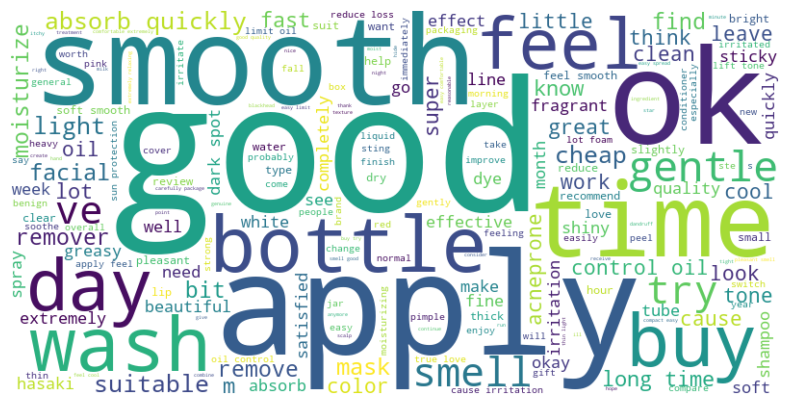

In [12]:
# Combine all words into a single string
all_words = ' '.join([word for sublist in translated_comment['cleaned_comment'] for word in sublist])

# Initialize a WordCloud object with desired parameters
wordcloud = WordCloud(width=800, height=400, background_color='white')

# Generate word cloud from the preprocessed string
wordcloud.generate(all_words)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis('off') 
plt.show()